In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys

In [2]:
sys.path

['d:\\Desktop\\Lipschitz_DSNN\\trial_notebooks',
 'd:\\anaconda_neel\\python38.zip',
 'd:\\anaconda_neel\\DLLs',
 'd:\\anaconda_neel\\lib',
 'd:\\anaconda_neel',
 '',
 'd:\\anaconda_neel\\lib\\site-packages',
 'd:\\anaconda_neel\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'd:\\anaconda_neel\\lib\\site-packages\\win32',
 'd:\\anaconda_neel\\lib\\site-packages\\win32\\lib',
 'd:\\anaconda_neel\\lib\\site-packages\\Pythonwin',
 'd:\\anaconda_neel\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\NEELKANTH RAWAT\\.ipython']

In [3]:
sys.path.append('D:\\Desktop\\Lipschitz_DSNN') 

Now I can start loading up the module and data and try to replicate some of the examples to understand the algorithm well

In [4]:
# let's load a saved configuration
import json

In [5]:
# Load the JSON file
file_config_training="D:\Desktop\Lipschitz_DSNN\configs\config_1d.json"
with open(file_config_training, 'r') as f:
    config = json.load(f)

config

{'activation_fn_params': {'activation_type': 'linearspline',
  'groupsort_groupsize': 5,
  'prelu_init': -1,
  'lipschitz_constrained': True,
  'spline_init': 'relu',
  'spline_range': 0.5,
  'spline_scaling_coeff': True,
  'spline_size': 101,
  'lmbda': 1e-07},
 'dataset': {'function_type': 'f1',
  'number_knots': 9,
  'testing_dataset_size': 10000,
  'training_dataset_size': 1000},
 'exp_name': 'test',
 'log_dir': '1d_exps/ortho',
 'net_params': {'bias': True,
  'layer_sizes': [1, 10, 10, 10, 1],
  'projection': 'orthonormalize',
  'weight_initialization': 'He_uniform'},
 'optimizer': {'lr_spline_coeffs': 5e-05,
  'lr_spline_scaling_coeffs': 0.0005,
  'lr_weights': 0.002},
 'seed': 5,
 'training_options': {'batch_size': 10,
  'epochs': 1000,
  'nbr_models': 25,
  'num_workers': 1}}

`BaseModel.py` and `simple_fc.py`: For Simple Fully Connected network

In [6]:
from architectures.simple_fc import SimpleFC

In [70]:
import torch
import torch.nn as nn
from architectures.base_model import BaseModel
from layers.lipschitzlinear import LipschitzLinear
from projections.fc_projections import identity, bjorck_orthonormalize_fc


class SimpleFCClassification(BaseModel):
    """simple architecture for a fully-connected network"""
    def __init__(self, network_parameters, **params):
        
        super().__init__(**params)

        modules = nn.ModuleList()

        if network_parameters['projection'] == 'no_projection':
            projection = identity
        elif network_parameters['projection'] == 'orthonormalize':
            if 'bjorck_iter' in network_parameters:
                def proj(weights, lipschitz_goal):
                    return bjorck_orthonormalize_fc(weights, lipschitz_goal,
                                                    beta=0.5, iters=network_parameters['bjorck_iter'])
                projection = proj
            else:
                projection = bjorck_orthonormalize_fc
        else:
            raise ValueError('Projection type is not valid')

        layer_sizes = network_parameters['layer_sizes']


        for i in range(len(layer_sizes)-2):
            modules.append(LipschitzLinear(1, projection, layer_sizes[i], layer_sizes[i+1]))
            modules.append(self.init_activation(('fc', layer_sizes[i+1])))


        modules.append(LipschitzLinear(1, projection, layer_sizes[-2], layer_sizes[-1]))
        modules.append(nn.Sigmoid())
        self.initialization(init_type=network_parameters['weight_initialization'])
        self.num_params = self.get_num_params()

        self.layers = nn.Sequential(*modules)
        

    def forward(self, x):
        """ """
        ### apply layers and sigmoid function
        x= self.layers(x)
        #x = torch.sigmoid(x)
        return x

Area Classification Problem

In [8]:
### Area Classification Problem
import numpy as np

# Given function g (vectorized)
g = lambda x: 0.4 * np.sin(-5*x)

# Define the label function (vectorized)
def S_shape_label_fn(coordinate_2d):
    x1, x2 = coordinate_2d[:, 0], coordinate_2d[:, 1]
    return np.logical_and(np.abs(x1 - g(x2)) <= 0.3, np.abs(x2) < 0.8).astype(int)

# Generate random x_mat
num_dp = 2000  # Assuming num_dp is defined
x_mat = np.random.uniform(-1, 1, size=(num_dp, 2))

# Create y_mat
y_mat = S_shape_label_fn(x_mat)

# Plotting
# plt.figure(figsize=(8, 6))
# plt.scatter(x_mat[y_mat == 1, 0], x_mat[y_mat == 1, 1], color='blue', label='Label 1')
# plt.scatter(x_mat[y_mat == 0, 0], x_mat[y_mat == 0, 1], color='yellow', label='Label 0')
# plt.title('2D Grid Plot of S_shape_label_fn')
# plt.xlabel('X1')
# plt.ylabel('X2')
# plt.legend()
# # plt.grid(True)
# plt.show()

In [9]:
from torch.utils.data import Dataset
### later transfer it to the 
class CustomDataset(Dataset):
    """
    Custom dataset class for our problem.
    """
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]
        return x, y


In [10]:
import torch
import os
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils import tensorboard
from architectures.simple_fc import SimpleFC
from utils import metrics, utilities, spline_utils
import matplotlib.pyplot as plt
from layers.lipschitzlinear import LipschitzLinear
from dataloader.Function_1D import (Function1D, generate_testing_set,
    slope_1_ae, slope_1_flat, cosines, threshold)
from activations.linearspline import LinearSpline

In [11]:
def slope_normalization(cs, T):
    lipschitz = torch.max(torch.abs(cs[:, 1:] - cs[:,:-1]), dim=1)[0]
    new_cs = T * torch.div(cs.T, lipschitz).T

    return new_cs

In [16]:
64*5

320

In [135]:
# writing a general trainer function for our classification problem
import torch
import os
import json
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
# from torch.utils import tensorboard
from utils import metrics, utilities

class Trainer_classification:
    """
    Trainer class for your classification problem.
    """
    def __init__(self, model, xdata, ydata, criterion, config, seed, device, print_after_epoch=5):
        self.model = model
        self.x = xdata
        self.y = ydata
        self.config = config
        self.device = device
        self.criterion = criterion 

        # Split dataset into train and validation sets
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(xdata, ydata,
                                                                    test_size=config["training_options"]["validation_split"], 
                                                                    random_state=seed)

        # Prepare dataloaders 
        self.train_dataloader = DataLoader(CustomDataset(self.x_train, self.y_train), 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=True)
        self.val_dataloader = DataLoader(CustomDataset(self.x_val, self.y_val), 
                                        batch_size=config["training_options"]["batch_size"], 
                                        shuffle=False)

        # Set up the optimizer 
        self.set_optimization()

        # average train and val epoch loss
        self.avg_train_loss_epoch=[]
        self.avg_val_loss_epoch = []
        self.train_acc_epoch = []
        self.val_acc_epoch = []


        ## for printing the result
        self.print_after=print_after_epoch

        # Stats to save about the models

    ### setting up the optimizer
    def set_optimization(self):
        """ """
        #for i in range(self.nbr_models):
        params_list = [{'params': spline_utils.get_no_spline_coefficients(self.model), \
                        'lr': self.config["optimizer"]["lr_weights"]}]
        if self.model.using_splines:
            params_list.append({'params': spline_utils.get_spline_coefficients(self.model), \
                                'lr': self.config["optimizer"]["lr_spline_coeffs"]})

            if self.config["activation_fn_params"]["spline_scaling_coeff"]:
                params_list.append({'params': spline_utils.get_spline_scaling_coeffs(self.model), \
                                    'lr': self.config["optimizer"]["lr_spline_scaling_coeffs"]})
        self.optimizer = torch.optim.Adam(params_list, weight_decay=0.0001)

    def train(self):
        """
        Main training loop.
        """
        for epoch in range(self.config["training_options"]["epochs"]):
            self.train_epoch(epoch)
            self.validate_epoch(epoch)
            if epoch % self.print_after ==0 :
                print(f"avg epoch train loss: {self.avg_train_loss_epoch[epoch]:.6f} and validation loss: {self.avg_val_loss_epoch[epoch]:.6f}")
                print(f"training acc: {self.train_acc_epoch[epoch]:.6f} and validation acc: {self.val_acc_epoch[epoch]:.6f}")
        # Need to add Additional post-training actions here
        ### (right now I dont wanna save my checkpoints)

    def train_epoch(self, epoch):
        """
        Train the model for one epoch.
        """
        self.model.train()
        total_train_loss=0
        tbar = tqdm(self.train_dataloader)
        for batch_idx, (data, target) in enumerate(tbar): #(self.train_dataloader):
            data, target = data.to(self.device), target.to(self.device)
            
            # Forward pass
            output = self.model(data)### output shape: (N,1)
            output = output.squeeze()

            # Compute loss
            data_loss = self.criterion(output, target.float())

            # TV2 regulatisation
            regularization=0
            if self.model and self.config['activation_fn_params']['lmbda'] > 0:
                regularization = self.config['activation_fn_params']['lmbda'] * self.model.TV2()
            # total loss
            total_loss = data_loss + regularization#data_loss #+ regularization
            ### Yippie I figured out the issue. it is with the data_loss term 

            # Backward pass and optimization
            self.optimizer.zero_grad()
            total_loss.backward()
            # update the parameters
            self.optimizer.step()

            total_train_loss+=total_loss
            # If need to add code to Log training progress
            # my training progress logging code goes here

        # average training loss for the epoch
        avg_train_loss = total_train_loss / len(self.train_dataloader)
        self.avg_train_loss_epoch.append(avg_train_loss.detach())

        # evaluating training accuracy
        with torch.no_grad():
            pred= self.model(torch.tensor(self.x_train))
            acc_train  = (pred.squeeze().round() == torch.tensor(self.y_train) ).float().mean()
            self.train_acc_epoch.append(acc_train)
        

    def validate_epoch(self, epoch):
        """
        Validate the model for one epoch.
        """
        self.model.eval()
        total_val_loss=0
        # Validation loop
        with torch.no_grad():
            for data, target in self.val_dataloader:
                data, target = data.to(self.device), target.to(self.device)
                
                # Forward pass
                output = self.model(data)
                output = output.squeeze()

                # Compute validation metrics (e.g., accuracy, loss)
                data_loss = self.criterion(output, target.float())
                total_val_loss+=data_loss

            avg_val_loss = total_val_loss / len(self.val_dataloader)
            self.avg_val_loss_epoch.append(avg_val_loss.detach())
            # # Calculating accuracy of model
            # acc_val  = (output.round() == target).float().mean
            # self.val_acc_epoch.append(acc_val)
            # evaluating training accuracy
            pred= self.model(torch.tensor(self.x_val))
            acc_val  = (pred.squeeze().round() == torch.tensor(self.y_val) ).float().mean()
            self.val_acc_epoch.append(acc_val)
            # Additional validation actions go here
        

    def save_checkpoint(self, epoch):
        """
        Save model checkpoint.
        """
        # Your checkpoint saving code goes here

    def load_checkpoint(self, checkpoint_path):
        """
        Load model checkpoint.
        """
        # Your checkpoint loading code goes here

    # Additional methods for logging, evaluation, etc. go here


In [153]:
### model parameters
network_param = {'bias': True,
    'layer_sizes': [2, 20, 1], ### we will consider 2-D Example later on
    'projection': 'orthonormalize',
    'weight_initialization': 'He_uniform'}

additional_network_params= {'activation_type': 'linearspline', ### this is of interest
    'groupsort_groupsize': 5,
    'prelu_init': -1,
    'lipschitz_constrained': True,### this is of interest
    'spline_init': 'relu',### this is of interest
    'spline_range': 0.9,### this is of interest [-1,1]
    'spline_scaling_coeff': True,### this is of interest
    'spline_size': 19,#101,###
    'lmbda': 1e-07}### this is of interest [e-10,e2]

for_optimizer = {'lr_spline_coeffs': 5e-05, # idk what exactly is this. Need to look into it well
    'lr_spline_scaling_coeffs': 0.0005,
    'lr_weights': 0.01}# 0.002

training_options = {'batch_size': 64*5,  
    'epochs': 20,
    'nbr_models': 1,
    'num_workers': 1,
    'validation_split':0.3}

config_train_classification = { 'activation_fn_params':additional_network_params,
                            'exp_name' : "S shaped classification",
                            'net_params' : network_param,
                            'optimizer' : for_optimizer,
                            'training_options' : training_options
}



~~Issue I am facing at the moment: No gradients are being evaluated for the weights and biases. So we are never learning any parameters which could be the reason why the loss is not decreasing.~~

100%|██████████| 5/5 [00:00<00:00, 25.16it/s]

avg epoch train loss: 0.684743 and validation loss: 0.646321
training acc: 0.723571 and validation acc: 0.681667



 60%|██████    | 3/5 [00:00<00:00, 25.70it/s]

avg epoch train loss: 0.606067 and validation loss: 0.609715
training acc: 0.769286 and validation acc: 0.715000


 40%|████      | 2/5 [00:00<00:00, 19.52it/s]

avg epoch train loss: 0.554478 and validation loss: 0.601309
training acc: 0.769286 and validation acc: 0.715000


 40%|████      | 2/5 [00:00<00:00, 18.40it/s]

avg epoch train loss: 0.550302 and validation loss: 0.597798
training acc: 0.769286 and validation acc: 0.715000


 40%|████      | 2/5 [00:00<00:00, 18.92it/s]

avg epoch train loss: 0.541376 and validation loss: 0.594710
training acc: 0.769286 and validation acc: 0.715000


 40%|████      | 2/5 [00:00<00:00, 17.13it/s]

avg epoch train loss: 0.543477 and validation loss: 0.592231
training acc: 0.769286 and validation acc: 0.715000


 40%|████      | 2/5 [00:00<00:00, 17.18it/s]

avg epoch train loss: 0.543799 and validation loss: 0.590055
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 23.17it/s]

avg epoch train loss: 0.543867 and validation loss: 0.586978
training acc: 0.769286 and validation acc: 0.715000


 40%|████      | 2/5 [00:00<00:00, 19.14it/s]

avg epoch train loss: 0.543091 and validation loss: 0.583866
training acc: 0.769286 and validation acc: 0.715000


 40%|████      | 2/5 [00:00<00:00, 14.49it/s]

avg epoch train loss: 0.539440 and validation loss: 0.581597
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 24.69it/s]

avg epoch train loss: 0.535766 and validation loss: 0.579930
training acc: 0.769286 and validation acc: 0.715000


100%|██████████| 5/5 [00:00<00:00, 27.36it/s]

avg epoch train loss: 0.533150 and validation loss: 0.577888
training acc: 0.769286 and validation acc: 0.715000



 60%|██████    | 3/5 [00:00<00:00, 22.29it/s]

avg epoch train loss: 0.536759 and validation loss: 0.576574
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 29.30it/s]

avg epoch train loss: 0.529200 and validation loss: 0.575096
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 20.29it/s]

avg epoch train loss: 0.526918 and validation loss: 0.575281
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 23.71it/s]

avg epoch train loss: 0.529652 and validation loss: 0.574007
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 22.05it/s]

avg epoch train loss: 0.525701 and validation loss: 0.572683
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 25.92it/s]

avg epoch train loss: 0.529635 and validation loss: 0.571115
training acc: 0.769286 and validation acc: 0.715000


 60%|██████    | 3/5 [00:00<00:00, 24.63it/s]

avg epoch train loss: 0.525920 and validation loss: 0.570696
training acc: 0.769286 and validation acc: 0.715000


100%|██████████| 5/5 [00:00<00:00, 25.00it/s]


avg epoch train loss: 0.528019 and validation loss: 0.570426
training acc: 0.769286 and validation acc: 0.715000


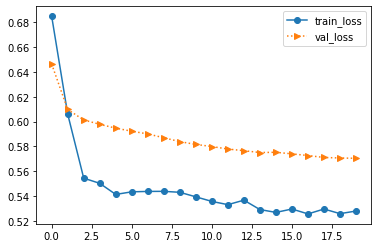

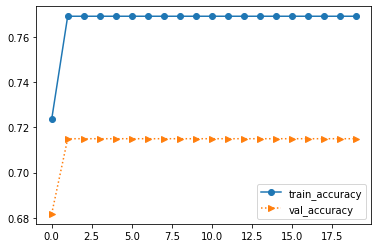

In [155]:
### let's club everything together
import torch.nn as nn
## data is : x_mat, y_mat
## criterion is: criterion
criterion= nn.BCELoss()

# model
### defining the model
ds_simple_fc_model= SimpleFCClassification(network_parameters=network_param,
                             **additional_network_params)
ds_simple_fc_model =ds_simple_fc_model.to('cpu')

### instantiate the Trainer 
trainer_classification = Trainer_classification(model=ds_simple_fc_model,
                                                xdata=x_mat,
                                                ydata= y_mat,
                                                criterion=criterion,
                                                config= config_train_classification, ## Need to add this
                                                seed=12,
                                                device='cpu',
                                                print_after_epoch=1
                                                )

### Let's train the model
trainer_classification.train() ### 

train_loss= trainer_classification.avg_train_loss_epoch
val_loss = trainer_classification.avg_val_loss_epoch
plt.plot(train_loss,"o-",label="train_loss")
plt.plot(val_loss, ">:",label="val_loss")
plt.legend()
plt.show()


### Let;s also plot the train and val accuracy
train_acc, val_acc = trainer_classification.train_acc_epoch, trainer_classification.val_acc_epoch
plt.plot(train_acc,"o-",label="train_accuracy")
plt.plot(val_acc, ">:",label="val_accuracy")
plt.legend()
plt.show()

Okay. I noticed this consistent pattern that whenever the accuracy of 

In [74]:
### test dataset
x_test= np.random.uniform(-1,1,size=(100,2))
y_test= S_shape_label_fn(x_test)

x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)

In [ ]:
trainer_classification.x_train, trainer_classification.y_train

In [156]:
with torch.no_grad():
    preds = ds_simple_fc_model(torch.tensor(trainer_classification.x_train))

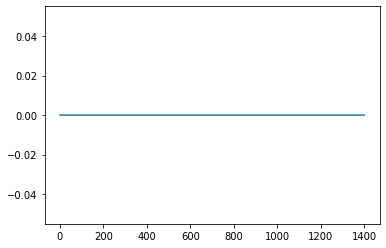

In [158]:
plt.plot(preds.round()) # it seems like everything is being predicted to 0

In [77]:
preds

tensor([[0.2860],
        [0.2713],
        [0.2200],
        ...,
        [0.1732],
        [0.2801],
        [0.2328]])

In [78]:
ds_simple_fc_model

SimpleFCClassification(
  (layers): Sequential(
    (0): LipschitzLinear(in_features=2, out_features=10, bias=True)
    (1): LinearSpline(mode=fc, num_activations=10, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (2): LipschitzLinear(in_features=10, out_features=10, bias=True)
    (3): LinearSpline(mode=fc, num_activations=10, init=relu, size=19, grid=0.100, lipschitz_constrained=True.)
    (4): LipschitzLinear(in_features=10, out_features=1, bias=True)
    (5): Sigmoid()
  )
)